In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from plotly.offline import iplot

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

#Pre-processing
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
import string
import warnings
warnings.filterwarnings('ignore')
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import L1, L2
import tensorflow as tf

from transformers import DistilBertTokenizerFast, TFDistilBertModel, DistilBertConfig
import time

- Load data from JSON
- Group by data by categories and select first 1000 observations from each category 
- Filter dataframe based on 6 categories
- Create the summary feature and subset the dataframe to contain only the summary and the category (target)

In [9]:
df = pd.read_json('../data/final_project/News_Category_Dataset_v2.json', lines=True)

In [10]:
df = df.groupby(by='category').head(1000)

category_list = ['POLITICS', 'ENTERTAINMENT', 'TRAVEL', 'BUSINESS', 'SPORTS', 'RELIGION']
df = df[df['category'].isin(category_list)]
df['summary'] = df['headline'] + '. ' +  df['short_description']
df = df[['summary','category']]

In [14]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_summary(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

df['summary'] = df['summary'].apply(clean_summary)

In [6]:
all_data = df['summary']
all_labels = df['category']

# Model 3: Tensorflow LSTM

In [7]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(all_data, pd.get_dummies(all_labels), train_size=.8,random_state=1)

# Hyperparameters

In [10]:
# Dealing with OOV
num_words = 50000 # Max number of words from tokenized vocab to be used
optimizer = 'adam'
metrics = ['accuracy']
activation = 'softmax'
embed_size = 100
loss = 'categorical_crossentropy'
batch_size = 64
num_epochs = 10
validation_split = 0.2

In [12]:
def tensorflow_preprocessing(num_words, X_train, X_test):

    # Tokenize training data
    tokenizer = Tokenizer(num_words=num_words, oov_token='UNK')    
    tokenizer.fit_on_texts(X_train)

    # Get training data word index
    word_index = tokenizer.word_index

    # Encode training and testing data sentences into sequences
    train_sequences = tokenizer.texts_to_sequences(X_train)
    test_sequences = tokenizer.texts_to_sequences(X_test)

    
    # Get max training sequence length
    maxlen = max([len(x) for x in train_sequences])
    
    # Pad train and test sequences
    train_padded = pad_sequences(train_sequences)
    test_padded = pad_sequences(test_sequences, maxlen=maxlen)
    
    return train_padded, test_padded, maxlen 

In [13]:
train_padded, test_padded, maxlen = tensorflow_preprocessing(num_words, X_train_v2, X_test_v2)

# Train the model

In [14]:
def tensorflow_models(model, optimizer, metrics, loss, batch_size, epochs, validation_split, 
                     train_padded, test_padded, y_train, y_test):
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model.summary()
    
    history = model.fit(train_padded, 
                             y_train, 
                             epochs=epochs, 
                             batch_size=batch_size, 
                             validation_split=validation_split)
    
    
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show();
    
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show();

- 1 embedding layer with a maximum 50000 words to be used from the vocabulary, an embed size of 100 and dynamic input length
- 1 LSTM layer with 100 nodes
- 1 dense output layer with 6 nodes and softmax activation function<br>
Our model uses the adam optimizer, a batch size of 64, the categorical cross entropy loss function,a 20% validation split and accuracy as the metric 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 81, 100)           5000000   
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                                 
Total params: 5,081,006
Trainable params: 5,081,006
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
60/60 [==============================] - 8s 106ms/step - loss: 1.7388 - accuracy: 0.2471 - val_loss: 1.5368 - val_accuracy: 0.4385
Epoch 2/10
60/60 [==============================] - 6s 96ms/step - loss: 1.2666 - accuracy: 0.5240 - val_loss: 1.1426 - val_accuracy: 0.5844
Epoch 3/10
60/60 [=======

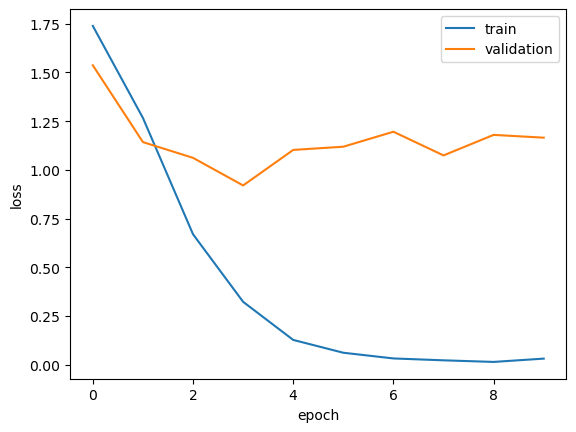

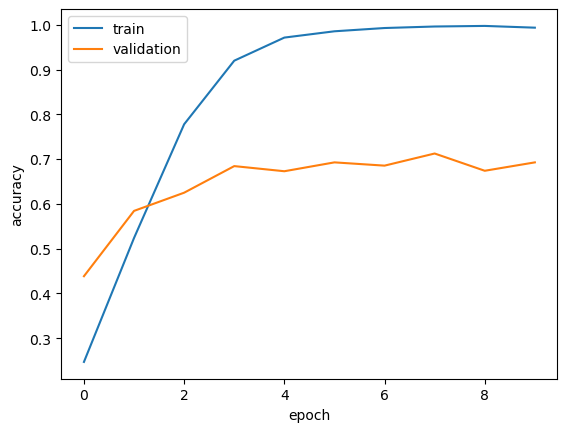

In [16]:
clear_session()
model3b = Sequential()
model3b.add(Embedding(num_words, embed_size, input_length=maxlen))
model3b.add(LSTM(100, dropout=0.2))

model3b.add(Dense(6, activation=activation))

tensorflow_models(model=model3b, 
                  optimizer=optimizer, 
                  metrics=metrics, 
                  loss=loss, 
                  batch_size=batch_size, 
                  epochs=num_epochs, 
                  validation_split=validation_split, 
                  train_padded=train_padded, 
                  test_padded=test_padded, 
                  y_train=y_train_v2, 
                  y_test=y_test_v2)

Add regularization

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 81, 100)           5000000   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 5,081,006
Trainable params: 5,081,006
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
60/60 [==============================] - 8s 107ms/step - loss: 2.3174 - accuracy: 0.2534 - val_loss: 2.0563 - val_accuracy: 0.3760
Epoch 2/10
60/60 [==============================] - 6s 98ms/step - loss: 1.7508 - accuracy: 0.4190 - val_loss: 1.7676 - val_accuracy: 0.4375
Epoch 3/10
60/60 [=========

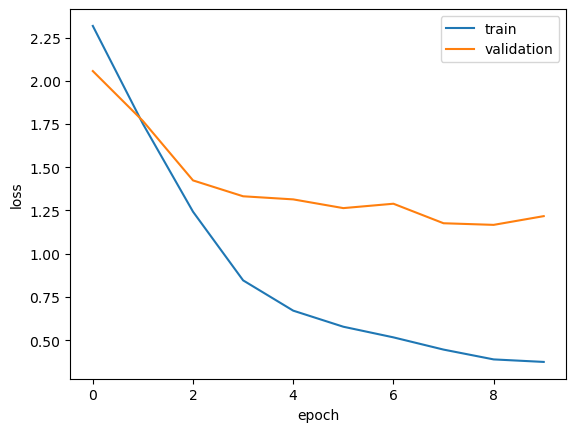

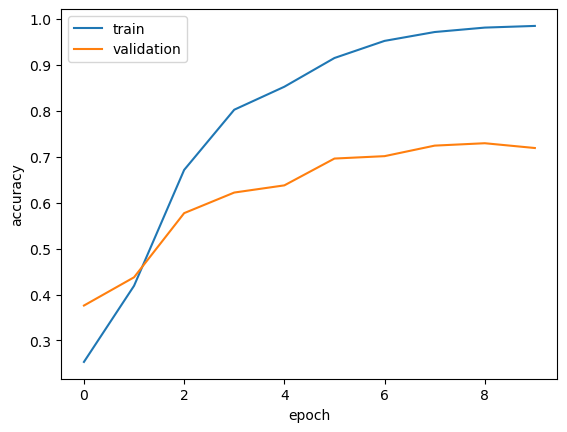

In [24]:
clear_session()
model3c = Sequential()
model3c.add(Embedding(num_words, embed_size, input_length=maxlen))
model3c.add(LSTM(100, dropout=0.2))

model3c.add(Dense(6, activation=activation, kernel_regularizer=L1(0.01), activity_regularizer=L2((0.01))))

tensorflow_models(model=model3c, 
                  optimizer=optimizer, 
                  metrics=metrics, 
                  loss=loss, 
                  batch_size=batch_size, 
                  epochs=num_epochs, 
                  validation_split=validation_split, 
                  train_padded=train_padded, 
                  test_padded=test_padded, 
                  y_train=y_train_v2, 
                  y_test=y_test_v2)

# Distilbert

## Tokenizing text

In [43]:
# Instantiate DistilBERT tokenizer...we use the Fast version to optimize runtime
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [44]:
# Define the maximum number of words to tokenize (DistilBERT can tokenize up to 512)
MAX_LENGTH = 128


# Define function to encode text data in batches
def batch_encode(tokenizer, texts, batch_size=256, max_length=MAX_LENGTH):
    """
    A function that encodes a batch of texts and returns the texts'
    corresponding encodings and attention masks that are ready to be fed 
    into a pre-trained transformer model.
    
    Input:
        - tokenizer:   Tokenizer object from the PreTrainedTokenizer Class
        - texts:       List of strings where each string represents a text
        - batch_size:  Integer controlling number of texts in a batch
        - max_length:  Integer controlling max number of words to tokenize in a given text
    Output:
        - input_ids:       sequence of texts encoded as a tf.Tensor object
        - attention_mask:  the texts' attention mask encoded as a tf.Tensor object
    """
    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             #padding='longest', #implements dynamic padding
                                             padding='max_length',
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [45]:
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train_v2.to_list())
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test_v2.to_list())

In [46]:
from transformers import TFDistilBertModel, DistilBertConfig

DISTILBERT_DROPOUT = 0.2
DISTILBERT_ATT_DROPOUT = 0.2
 
# Configure DistilBERT's initialization
config = DistilBertConfig(dropout=DISTILBERT_DROPOUT, 
                          attention_dropout=DISTILBERT_ATT_DROPOUT, 
                          output_hidden_states=True)
                          
# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states 
# and without any specific head on top.
distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

# Make DistilBERT layers untrainable
for layer in distilBERT.layers:
    layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [47]:
MAX_LENGTH = 128
LAYER_DROPOUT = 0.2
LEARNING_RATE = 5e-5
RANDOM_STATE = 42

def build_model(transformer, max_length=MAX_LENGTH):
    """
    Template for building a model off of the BERT or DistilBERT architecture
    for a binary classification task.
    
    Input:
      - transformer:  a base Hugging Face transformer model object (BERT or DistilBERT)
                      with no added classification head attached.
      - max_length:   integer controlling the maximum number of encoded tokens 
                      in a given sequence.
    
    Output:
      - model:        a compiled tf.keras.Model with added classification layers 
                      on top of the base pre-trained model architecture.
    """
    
    # Define weight initializer with a random seed to ensure reproducibility
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=RANDOM_STATE) 
    
    # Define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    
    # DistilBERT outputs a tuple where the first element at index 0
    # represents the hidden-state at the output of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    
    # We only care about DistilBERT's output for the [CLS] token, 
    # which is located at index 0 of every encoded sequence.  
    # Splicing out the [CLS] tokens gives us 2D data.
    cls_token = last_hidden_state[:, 0, :]
    
    # Define a 6 nodes that makes up the output layer (for multi-class classification)
    output = tf.keras.layers.Dense(6, 
                                   activation='softmax',
                                   kernel_initializer=weight_initializer,  
                                   kernel_regularizer=L1(0.01), 
                                   activity_regularizer=L2(0.01),
                                   bias_initializer='zeros'
                                   )(cls_token)
    
    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    # Compile the model
    model.compile(tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    
    return model

In [48]:
model = build_model(distilBERT)

In [50]:
EPOCHS = 6
BATCH_SIZE = 64

# Train the model
train_history1 = model.fit(
    x = [X_train_ids, X_train_attention],
    y = np.asarray(y_train_v2),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = ([X_test_ids, X_test_attention], np.asarray(pd.get_dummies(y_test_v2))),
    verbose=1
)

Epoch 1/6
75/75 [==============================] - 449s 6s/step - loss: 3.6721 - accuracy: 0.2194 - val_loss: 3.5751 - val_accuracy: 0.2817
Epoch 2/6
75/75 [==============================] - 451s 6s/step - loss: 3.5142 - accuracy: 0.2646 - val_loss: 3.4200 - val_accuracy: 0.3625
Epoch 3/6
75/75 [==============================] - 461s 6s/step - loss: 3.3819 - accuracy: 0.3194 - val_loss: 3.2874 - val_accuracy: 0.4375
Epoch 4/6
75/75 [==============================] - 456s 6s/step - loss: 3.2639 - accuracy: 0.3683 - val_loss: 3.1671 - val_accuracy: 0.4875
Epoch 5/6
75/75 [==============================] - 457s 6s/step - loss: 3.1508 - accuracy: 0.4123 - val_loss: 3.0558 - val_accuracy: 0.5267
Epoch 6/6
75/75 [==============================] - 462s 6s/step - loss: 3.0420 - accuracy: 0.4590 - val_loss: 2.9513 - val_accuracy: 0.5742


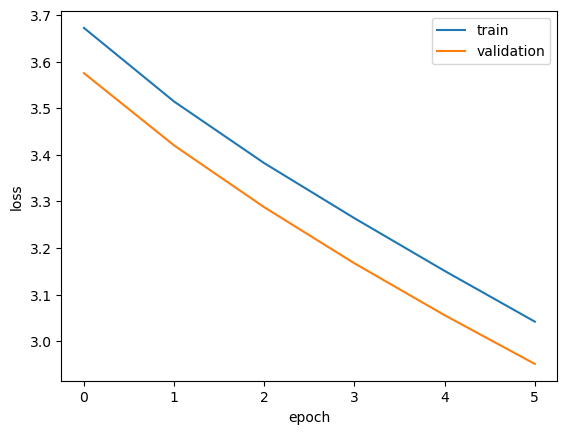

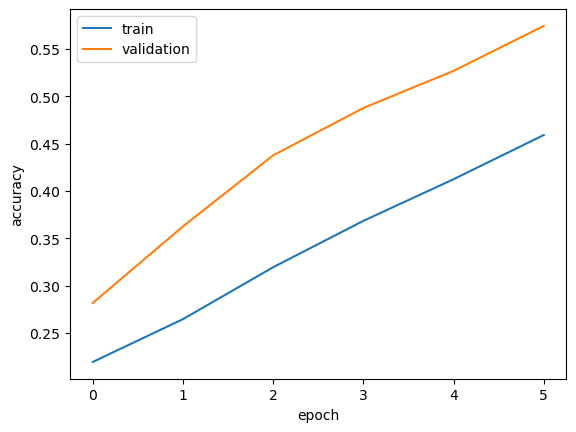

In [51]:
plt.plot(train_history1.history['loss'], label='train')
plt.plot(train_history1.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show();

plt.plot(train_history1.history['accuracy'], label='train')
plt.plot(train_history1.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show();

# Fine-tuning

In [53]:
FT_EPOCHS = 6
BATCH_SIZE = 64
#NUM_STEPS = len(X_train.index)

# Unfreeze distilBERT layers and make available for training
for layer in distilBERT.layers:
    layer.trainable = True
    
# Recompile model after unfreezing
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), #Changed learning rate
              loss=loss,
              metrics=['accuracy'])

# Train the model
train_history2 = model.fit(
    x = [X_train_ids, X_train_attention],
    y = np.asarray(y_train_v2),
    epochs = FT_EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = ([X_test_ids, X_test_attention], np.asarray(y_test_v2)),
    verbose=1
)

Epoch 1/6
75/75 [==============================] - 1113s 15s/step - loss: 2.0683 - accuracy: 0.8019 - val_loss: 1.7809 - val_accuracy: 0.8825
Epoch 2/6
75/75 [==============================] - 1062s 14s/step - loss: 1.7240 - accuracy: 0.8948 - val_loss: 1.6919 - val_accuracy: 0.8950
Epoch 3/6
75/75 [==============================] - 1067s 14s/step - loss: 1.5900 - accuracy: 0.9258 - val_loss: 1.6707 - val_accuracy: 0.8967
Epoch 4/6
75/75 [==============================] - 1071s 14s/step - loss: 1.4815 - accuracy: 0.9515 - val_loss: 1.6581 - val_accuracy: 0.8983
Epoch 5/6
75/75 [==============================] - 1067s 14s/step - loss: 1.4048 - accuracy: 0.9625 - val_loss: 1.6356 - val_accuracy: 0.9017
Epoch 6/6
75/75 [==============================] - 1067s 14s/step - loss: 1.3380 - accuracy: 0.9769 - val_loss: 1.6104 - val_accuracy: 0.9042


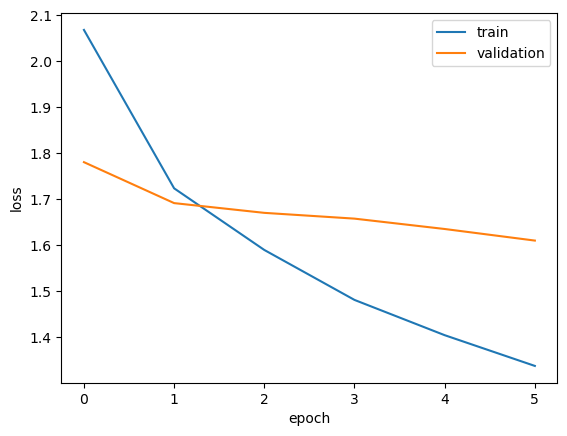

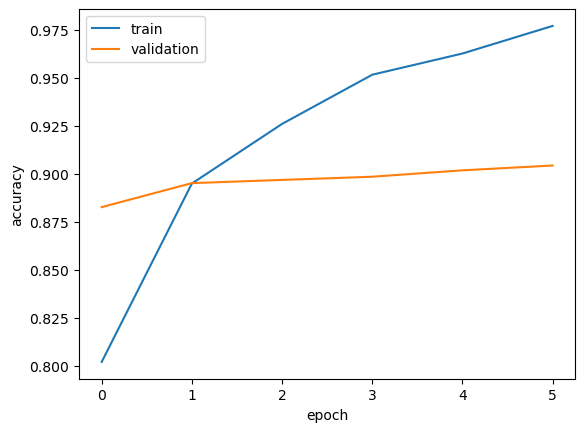

In [54]:
plt.plot(train_history2.history['loss'], label='train')
plt.plot(train_history2.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show();

plt.plot(train_history2.history['accuracy'], label='train')
plt.plot(train_history2.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show();